# Problem set 3 (43 + 35 = 78 pts)

# Making GANs great (43 pts)

GAN is typical example of high quality generative model. But we are still able to improve it. $G$ is model which maps latent distribution $p_z$ to the output $p_g$. Learning such $G$ that $p_g$ match original data distribution $p_d$ is quite complex task. In general $p_z$ is modeled by normal distribution. The reason for that is simplicity of sampling. But doing this we apply strong limitations on our model. It results in huge number of bad samples (non realistic images). To fix this problem we will correct latent distribution - decrease probability for "bad" samples and increase for "good" ones. Defining the criteria of "good" is not simple in general. So to find solution let's consider derivation for optimal discriminator:

$$D^*(x) = \frac{p_d(x)}{p_d(x) + p_g(x)}$$

Defining $d(x) = \mathrm{logit}(D(x))$ we can rewrite previous expression:

$$p_d(x) = p_g(x)\exp(d(x))$$

Since $p_g(x)$ induced by $p_z$ and $G$:

$$p^*(z) = p_z(z)\exp(d(G(z)))$$

We found the corrected distribution. Similar steps can be applied to non-standard GANs such as Wasserstein GAN (WGAN).

In this task you will be asked to improve the quality by correction of latent distribution for WGAN. An obvious question to ask is: "Why do we take WGAN?". You will answer it by yourself!

## Theoretical part (10 pts)

Suppose we have two 2D distributions: $P_\theta(x,\theta)$ and $P_*(x,\theta^*)$, where $\theta$ some parameter, $\theta^*$ is known fixed value, $x$ is random variable which has uniform distribution $x \sim U(0,1)$. In other words we have two horisontal lines in 2D space with certain $y$ position and $x$ uniformly distributed on the segment [0,1]. Find analytically distance between this distributions in different metrics for all possible values of $\theta$: 

1) KL divergence (2 pts)

2) JS divergence (3 pts)

3) Wasserstein distance (3 pts)

Suppose we would like to optimize parameter $\theta$ in order to fit target distribution $P_*$ with our parametrised distribution $P_\theta$. Which distance will you choose for this task? Why? (2 pts)

## Practical part

Here you will implement WGAN-GP and train it!

In [ ]:
!pip install -q git+https://github.com/kwotsin/mimicry.git torchmetrics torch-fidelity gdown

In [ ]:
import torch
import torch_mimicry as tmim
import torchvision as tv
import gdown

For simplicity we will take architectures for generator and discriminator from open source library torch-mimicry (you are free to change output size of model)

In [ ]:
G = tmim.nets.wgan_gp.wgan_gp_64.WGANGPGenerator64()
D = tmim.nets.wgan_gp.wgan_gp_64.WGANGPDiscriminator64()

## Your work starts here

### The first task is to implement loss functions for WGAN-GP (8 pts)

1) Implement loss function for discriminator (1 pts)

2) Implement loss function for generator (1 pts)

3) Implement gradient penalty for discriminator optimization (6 pts)

In [ ]:
def loss_D(d_fake,d_real):
    # define the loss of discriminator based on d_fake = D(G(z)) and d_real = D(x)
    return loss

In [ ]:
def loss_G(d_fake):
    # define the loss of generator based on output_fake = D(G(z))
    return loss

The most important moment in training WGAN-GP is gradient penalty. It is added to discriminator loss to ensure stability. Your goal is to implement following steps:

1) For given $N$ real images $x_{\mathrm{real}}$ and $N$ fake images $x_{\mathrm{fake}}$ compute random interpolation between real and fake samples in following way:

(use .detach() function over $x_{\mathrm{fake}}$ in order to get tensor without gradient graph)

$$x_{\mathrm{interpolation}} = \alpha x_{\mathrm{real}} + (1-\alpha)x_{\mathrm{fake}}$$

where $\alpha \sim U(0,1)$ (sampled from uniform distribution), $x_{\mathrm{real}}$ is of size $[N,3,H,W]$, $x_{\mathrm{fake}}$ is of size $[N,3,H,W]$ and $\alpha$ is of size $[N]$

2) Compute gradient of discriminator output with respect to input (interpolated samples)

$$\nabla D(x_{\mathrm{interpolation}})$$

It will be of size $[N,3,H,W]$, for ease of use reshape it to $[N,3HW]$

3) Compute loss:

$$\mathcal{L} = \mathrm{E}(\|\nabla D(x_{\mathrm{interpolation}})\|_2 - 1)^2$$

Second norm $\|\cdot\|_2$ is taken over second dimension (after reshaping in previous step), mean $\mathrm{E}$ is taken over first dimension. 

In [ ]:
def loss_GP(x_fake,x_real,D):
    # compute gradient penalty

### The second task is to implement standard stuff: (6 pts)

1) Download Celeba dataset, apply appropriate data transformation, create dataloader (3 pts)

You can use batch size equal 64. Do not forget to use materials shared on seminars!

2) Initialize optimizers for discriminator and generator (3 pts)

You can take Adam optimizer with **lr** $= 2\cdot 10^{-4}$, $\beta_1$ = 0 and $\beta_2$ = 0.9

In [ ]:
# your code is here

### The third task is to implement (6 pts)

1) For number of discriminator training iterations **n_dis** optimize total discriminator loss (standard loss + gradient penalty)

$$\mathcal{L}_D = \mathrm{loss}_\mathrm{D}(d_\mathrm{fake},d_\mathrm{real}) + \mathrm{gp}_\mathrm{scale}\mathrm{loss}_{\mathrm{GP}}(x_\mathrm{fake}, x_\mathrm{real},D)$$

You can take $\mathrm{gp}_\mathrm{scale} = 10$, **n_dis** = 2. Use previously implemented functions

2) Optimize generator loss

Use previously implemented functions

3) Repeat steps 1) and 2) for large number of iterations (for example 100k, but you can stop earlier if good result found)

**Upload the weights of trained model to cloud storage (e.g. Google Drive) and add sharing link here**

In [ ]:
def train(G,D,dataloader,n_dis,gp_scale):
    # your code is here

### The fourth task is to check model performance (3 pts)

1) Evaluate the FID metric for your model (3 pts)

Do not forget to use materials shared on seminars!

### The last task is to improve performance by correcting latent code sampling procedure (10 pts)

In this part you will implement I-SIR method to sample latent codes from corrected latent distribution and evaluate model performance with updated sampling using FID metric.

#### I-SIR (7 pts)

Algorithm:

* Sample $z \sim N(0,1)$ of shape $[N_s,1,n_z]$, where $n_z$ - size of latent space (128 for our model)

* FOR number of iterations $N_i$:
    * Sample additional particles $z_{\mathrm{add}} \sim N(0,1)$ of shape $[N_s,N_p,n_z]$
    * Concatenate $z$ with $z_{\mathrm{add}}$ along second dimension and reshape to the form $[-1,n_z]$. The result will be new $z$ of size $[N_s(N_p+1),n_z]$
    * Compute logarithm of density for new $z$ 
    
    $\log\rho(z) = -\frac{||z||_2^2}{2} + D(G(z))$ 
    
    and reshape result to the size $[N_s,N_p+1]$.
    * Make element-wise sampling from log density: fix first index and sample second one with respect to corresponding log density value (consider torch.distributions.Categorical). The result will be $idxs$ of size $[N_s]$.
    * Take particles according to sampled indexs $z = z[torch.arange(N_s),idxs]$.
* Return new samples $z$

#### Evaluate model using new sampling procedure (3 pts)

Compute FID metric by sampling latent code using I-SIR function. Leave a comment on obtained results.

In [ ]:
def I_SIR(N_i,N_s,N_p,n_z,D,G):
  # your code is here

#Problem 2. Signal processing (35 pts)

In this problem you are supposed to classify Electroencephalography (EEG) signals. You can solve the problem in two ways of your choice - using contrastive learning or using transformer.

##Dataset:

You will work with [EEG Motor Movement/Imagery Dataset (Sept. 9, 2009, midnight)](http://www.physionet.org/physiobank/database/eegmmidb/).
This data set consists of one-minute EEG recordings, obtained from 109 volunteers. 

We will consider Motor Imagenary experiment - a subject imagine opening and closing left or right fist. A target appears on either the left or the right side of the screen. The subject imagines opening and closing the corresponding fist until the target disappears. Then the subject relaxes.

The task is binary classify left and right hand movements from eeg signal.

Data loading \& requirements installation:

In [ ]:
!pip install -q mne
!pip install -q torcheeg

In [ ]:
import os
import mne
import numpy as np
from torcheeg import transforms
from torcheeg.datasets import MNEDataset

In [ ]:
metadata_list = [{
    'subject': subject_id,
    'run': run_id
} for subject_id in range(1, 100) # download of experiment data for subjects 1-100 (during debbuging you can take data for fewer subjects)
                 for run_id in [4, 8, 12]]  # Motor imagery experiment: left vs right hand

epochs_list = []
for metadata in metadata_list:
    physionet_path = mne.datasets.eegbci.load_data(metadata['subject'],
                                                   metadata['run'],
                                                   update_path=False)[0]
    raw = mne.io.read_raw_edf(physionet_path, preload=True, stim_channel='auto')
    mne.datasets.eegbci.standardize(raw)

    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)

    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
    events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))
    picks = mne.pick_types(raw.info,
                           meg=False,
                           eeg=True,
                           stim=False,
                           eog=False,
                           exclude='bads')
    epochs_list.append(
        mne.Epochs(raw,
                   events,
                   dict(left=2, right=3),
                   tmin=-1.,
                   tmax=4.0,
                   proj=True,
                   picks=picks))

Let's see what the EEG recording looks like:

In [ ]:
raw

<RawEDF | S009R12.edf, 64 x 19680 (123.0 s), ~9.7 MB, data loaded>

<RawEDF | S024R12.edf, 64 x 19680 (123.0 s), ~9.7 MB, data loaded>


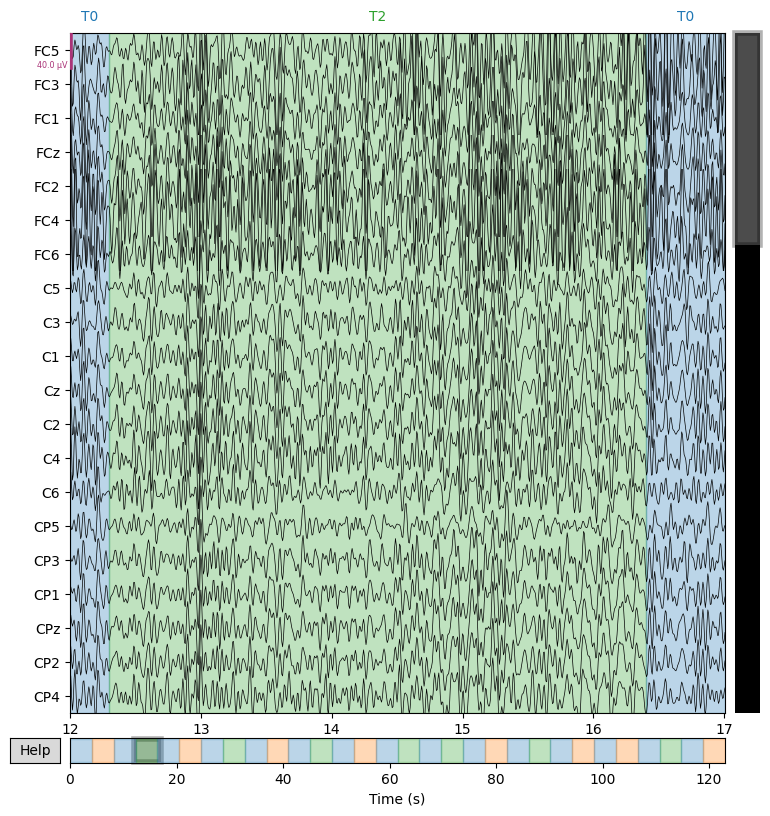

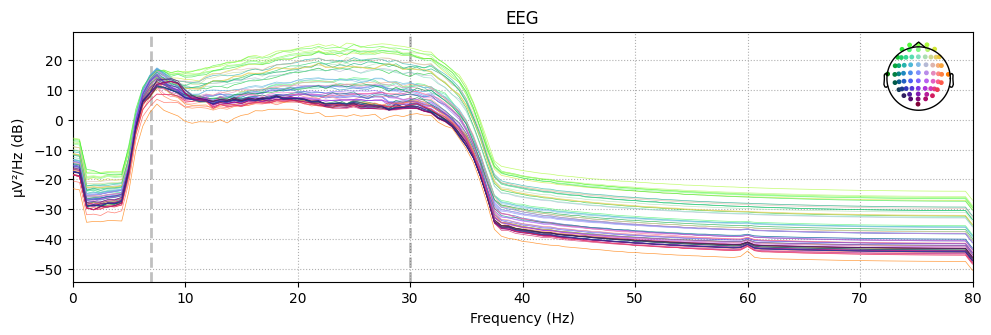

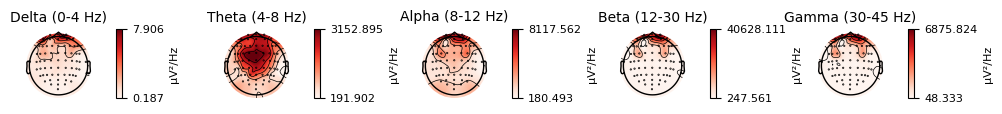

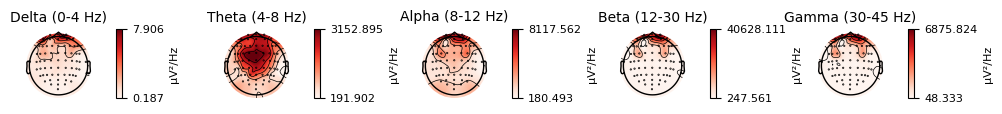

In [ ]:
raw.plot(start = 12, duration = 5)
raw.compute_psd().plot()
epochs_list[-1].compute_psd().plot_topomap()

In [ ]:
print(raw._data)
print("One sample data shape: ", raw._data.shape[0], "chanels x",  raw._data.shape[1], "signal length")

[[ 6.35274710e-21  1.86611651e-05  3.42197678e-05 ... -1.52334773e-05
  -3.85637085e-05 -1.80550406e-20]
 [ 6.77626358e-21  1.87280616e-05  3.72252049e-05 ... -1.63988425e-05
  -4.20347276e-05 -7.87040495e-21]
 [-5.08219768e-21 -1.14410068e-05 -5.38224628e-06 ... -2.22271020e-06
  -1.22207708e-05 -8.04668659e-21]
 ...
 [ 1.27054942e-21 -2.66154192e-06  6.40116723e-07 ...  1.70915837e-05
   1.16214476e-05 -8.90840530e-22]
 [ 8.47032947e-22 -2.38405112e-06  1.08601173e-06 ...  1.73443198e-05
   1.16450280e-05 -2.04590430e-21]
 [ 7.62329653e-21 -1.64084351e-06  6.83110656e-08 ...  2.15014400e-05
   1.51582896e-05 -2.43161448e-21]]
One run data shape:  64 chanels x 19680 signal length




Converting data into a usable form [[useful link]](https://torcheeg.readthedocs.io/en/latest/auto_examples/examples_mne_dataset.html):

In [ ]:
dataset = MNEDataset(epochs_list=epochs_list,
                     metadata_list=metadata_list,
                     chunk_size=160,
                     overlap=80,
                     io_path='./tmp_out/dataset/physionet',
                     offline_transform=transforms.Compose(
                         [transforms.MeanStdNormalize(),
                          transforms.To2d()]),
                     online_transform=transforms.ToTensor(),
                     label_transform=transforms.Compose([
                         transforms.Select('event'),
                         transforms.Lambda(lambda x: x - 2)
                     ]),
                     num_worker=2)

##Contrastive learning approach (35 pts)


Obtaining EEG signals is generally straightforward, but labeling them is a costly and challenging task that requires extensive medical training. Additionally, EEG datasets often have noisy labels and limited numbers of subjects (less than 100). While supervised learning has been commonly used in the EEG signal analysis field, it has limitations in terms of generalization performance due to the scarcity of annotated data. Self-supervised learning, which is a popular learning paradigm in CV and NLP, can leverage unlabeled data to compensate for the shortage of supervised learning data.

Related articles:
*   http://proceedings.mlr.press/v136/mohsenvand20a/mohsenvand20a.pdf
*   https://arxiv.org/abs/2109.07839
*   https://arxiv.org/pdf/2106.14112.pdf


Your task is to adapt and fine-tune SimCLR to the problem. You are free to implement the task in any way. 

However, suggested pipeline is:


* Channel recombination (3pts)

To obtain additional valid channels from a multi-channel EEG recording, it is possible to recombine channels. Each channel of an EEG captures the voltage difference between a sensor and a common reference. By subtracting the voltage readings from two channels, a new channel can be created that represents the voltage difference between those two sensors. This approach can yield additional channels with meaningful neurophysiological information.


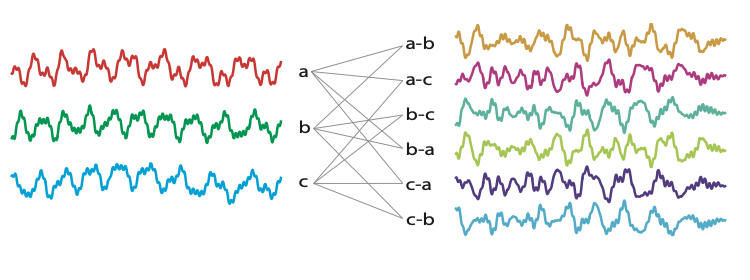


* Channel augmentations (3pts)

An essential element of the contrastive learning approach involves augmentations that do not affect the semantic information of data. A contrastive learning algorithm learns representations that are maximally similar for augmented instances of the same data-point and minimally similar for differ- ent data-points. For instance, the rotation of images or amplifying the amplitude of audio signals can significantly alter the numerical values of data, but not its meaning. Identifying a set of these augmentations can enable us to construct a self-supervised pretext task with the goal of generating features that are invulnerable to transformations and preserve the crucial content of EEG signals.


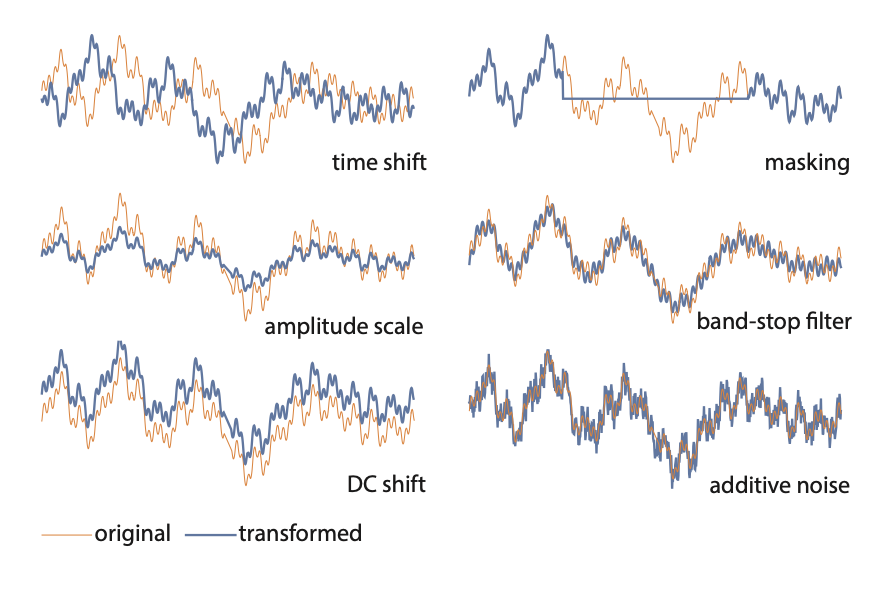

Modification variant of SimCLR proposed for EEG classification:

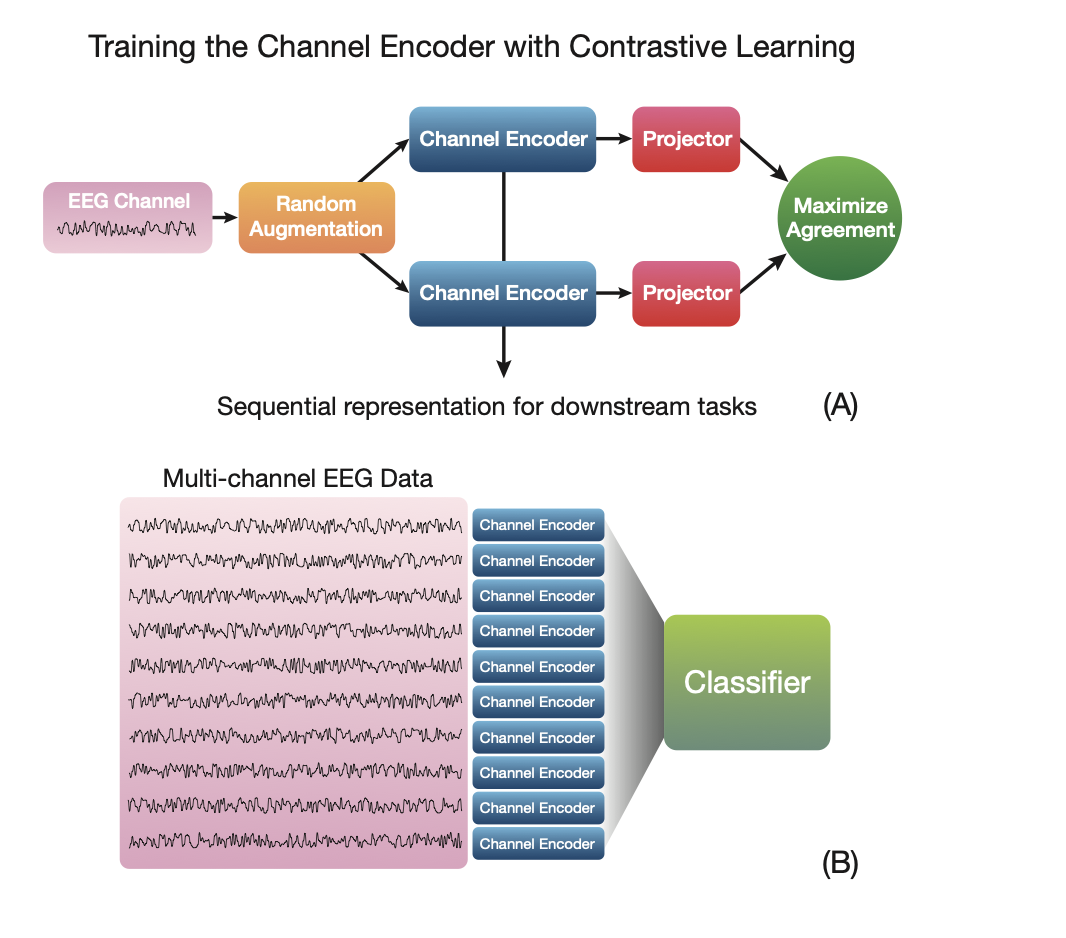

The model pipline consist of following bloks:


1. **Channel Encoder** (see picture below (A) and (B)) (4pts)
2. **Projector** (see picture below (C)) (4pts)
3. **Contrastive Loss** (4pts) Given a set $\left\{\boldsymbol{x}_k\right\}$ including a positive pair of channels $\boldsymbol{x}_i$ and $\boldsymbol{x}_j$, the contrastive task aims to identify $\boldsymbol{x}_j$ in $\left\{\boldsymbol{x}_k\right\}_{k \neq i}$ for a given $\boldsymbol{x}_i$. Assuming that $\boldsymbol{z}_i$ and $\boldsymbol{z}_j$ are the outputs of the projector for the positive pair of $\boldsymbol{x}_i$ and $\boldsymbol{x}_j$, the NT-Xent loss term for the positive pair is defined as:
$$
\ell_{i, j}=-\log \frac{\exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_j\right) / \tau\right)}{\sum_{k \neq i}^{2 N} \exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_k\right) / \tau\right)},
$$
where $\operatorname{sim}(\boldsymbol{u}, \boldsymbol{v})$ is the cosine similarity of $\boldsymbol{u}$ and $\boldsymbol{v}$ and $\tau$ is the temperature parameter. The final loss is the average of $\ell_{i, j}$ for all positive pairs in both orders $(i, j$ and $j, i)$.

4. **Classifier** (4pts)
A classifier almost identical to the projector with two differences: (1) the output dimension of the last dense layer is set to the number of classes (two in the current problem), and (2) a LogSoftmax layer is added afterward. 

(See more details in [paper](http://proceedings.mlr.press/v136/mohsenvand20a/mohsenvand20a.pdf))

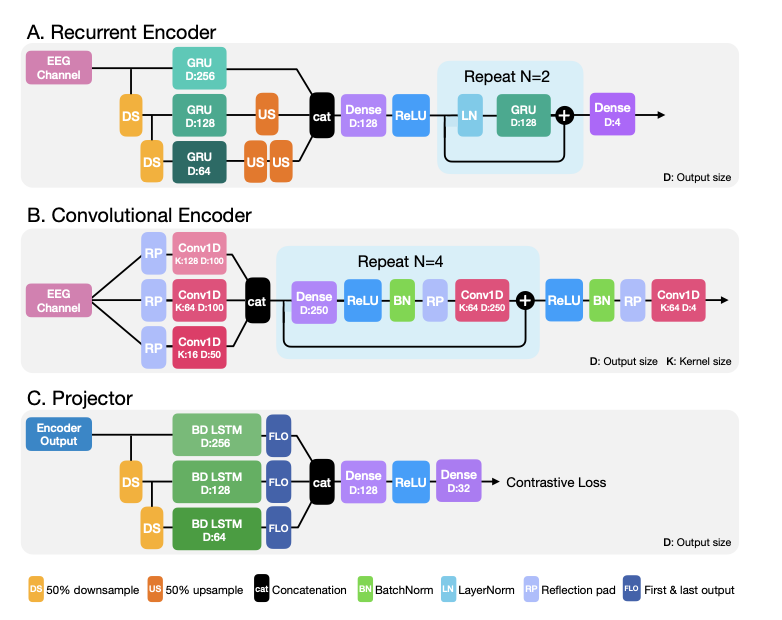

* **Data loader, Train loop \& Model trainig** (8pts)

* **Evaluate model**

Provide confusion matrix, F1 score, and loss curve.(3pts)

Report on obtained results.(2pts)





**You need to implement ONE of the two approaches!**

In [ ]:
### your code is here

##Transformer approach (35 pts)

The Transformer architecture has primarily found fame in processing natural language due to its excellent aptitude for analyzing long-range dependencies - this is beyond the fundamental capabilities delivered by conventional neural networks like CNN and RNN. As EEG classification significantly relies on capturing sequential relationships within the vast array of channels and time points, it has proven to be a difficult task, one that has frequently depended on pre-processing and hands-on feature extraction. However, deep learning with Transformer networks can remove the need for these preliminary steps by leveraging the attention mechanism to extract feature correlations in long-sequential EEG data, which helps visualize the model and appreciate the crucial spatial and temporal relationships in the raw data.

Related articles:
* https://www.nature.com/articles/s41598-022-18502-3
* https://arxiv.org/abs/2202.05170
* https://ieeexplore.ieee.org/document/9391844


In this task you need to implement transformer (you can use ViT transformers, but as a patch you need to use slice - signals splitted along the time dimension) *from scrath* .

**You need to implement ONE of the two approaches!**

###Code blocks (12 pts)

In [ ]:
class AttentionBlock(torch.nn.Module):
    def __init__(self):      
      ### your code is here
      pass
    def forward(self):
      ### your code is here
      pass
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self):
      ### your code is here
      pass                    
    def forward(self):
      ### your code is here
      pass
  
class PositionalEncoding(nn.Module):
    def __init__(self):
      ### your code is here
      pass
    def forward(self, x):
      ### your code is here
      pass 

class EncoderLayer(torch.nn.Module):
    def __init__(self):
      ### your code is here
      pass      
    def forward(self):
      ### your code is here
      pass
  
class DecoderLayer(torch.nn.Module):
    def __init__(self):
      ### your code is here
      pass          
    def forward(self):
      ### your code is here
      pass
  
class Transformer(torch.nn.Module):
      ### your code is here
      pass

* **Data loader, Train loop \& Model trainig** (8pts)

* **Evaluate model**

Provide confusion matrix, F1 score, and loss curve.(3pts)

Report on obtained results.(2pts)


###Efficient transformers (10 pts)

One of the key issues in a transformer is its quadratic complexity in relation to the length of the input sequence. This quadratic complexity can be computationally expensive, making it harder to scale transformers to longer sequences. Specifically, computing the attention matrix requires an $O(N^2)$ operation per layer, where $N$ is the length of the input sequence. This makes training and inference for large input sequences infeasible due to limitations in the available computational resources. 


Propose 2 implementation of eficient transformers, provide references and main idea of selected approaches. (2 pts)

Implement one of the approaches, compare inference with the previous model, make a conclusion. (8 pts)


In [ ]:
### your code is here